In [2]:
import deepSI
from NonlinearController.systems import SinCosUnbalancedDisc, UnbalancedDisc, ReversedUnbalancedDisc, ReversedSinCosUnbalancedDisc
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import random
from scipy.signal import cont2discrete, lti, dlti, place_poles
import torch

In [2]:
def randomLevelReference(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*random.uniform(level_range[0],level_range[1])))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

class Controller_pid(object):
    def __init__(self,kP,kI=0,kD=0):
        super(Controller_pid,self).__init__()
        self.kD = kD
        self.kP = kP
        self.kI = kI
        self.reset()

    def reset(self):
        self.t = 0
        self.E_old = None
        self.E_I = None

    def __call__(self,y,ref):
        E = ((y-ref)+np.pi)%(2*np.pi) - np.pi
        if self.E_old is None:
            self.E_old = E
            self.E_I = E
        else:
            self.E_I = self.E_I + E
        dE = E-self.E_old
        u = -self.kP*E-self.kD*dE-self.kI*self.E_I
        self.E_old = E
        self.t += 1
        return u

In [ ]:
# declare system and run simulation using input
dt = 0.1; sigma_n = [0.015]
# r_system = ReversedSinCosUnbalancedDisc(dt=dt, sigma_n=sigma_n)
r_system = ReversedUnbalancedDisc(dt=dt, sigma_n=sigma_n)
r_system.reset_state()
# system = SinCosUnbalancedDisc(dt=dt, sigma_n=sigma_n)
system = UnbalancedDisc(dt=dt, sigma_n=sigma_n)
system.reset_state()

train_datasets = deepSI.System_data_list()

Nu = 30; a = 12; begin_u = 10

for i in range(800):
    u = deepSI.deepSI.exp_design.multisine(Nu, pmax=Nu//2-1, n_crest_factor_optim=20)
    u = u/(max(u)-min(u))*a
    u = np.hstack((np.zeros(begin_u),u))
    data = system.apply_experiment(deepSI.System_data(u=u))
    train_datasets.append(data)
    data = r_system.apply_experiment(deepSI.System_data(u=u))
    train_datasets.append(data)

In [ ]:
val_datasets = deepSI.System_data_list()

for i in range(100):
    u = deepSI.deepSI.exp_design.multisine(Nu, pmax=Nu//2-1, n_crest_factor_optim=20)
    u = u/(max(u)-min(u))*a
    data = system.apply_experiment(deepSI.System_data(u=u))
    val_datasets.append(data)
    data = r_system.apply_experiment(deepSI.System_data(u=u))
    val_datasets.append(data)

In [ ]:
## -----------------------  Start Energy Controller ------------------------------
# declare system and run simulation using input
dt = 0.05; sigma_n=[0.014]; system = UnbalancedDisc(dt=dt,sigma_n=sigma_n)
system.reset_state()

# generate reference signal to be tracked
N_samples = int(10000/dt)
# r = np.ones(N_samples)*np.pi
r = randomLevelReference(N_samples, [int(1./dt),int(1.5/dt)], [-np.pi,np.pi])
# generate disturbance applied to controller output before system input
u_sin = deepSI.deepSI.exp_design.multisine(N_samples, pmin=N_samples//16, pmax=N_samples//2-1, n_crest_factor_optim=10)*2.5

# determince controller for linearized system and chosen poles
J = 0.000244210523960356
M = 0.0761844495320390
g = 9.80155078791343
l = 0.0410772235841364
Km = 10.5081817407479
tau = 0.397973147009910

theta_eq = r[0]; u_eq = M*g*l*tau*np.sin(theta_eq)/(Km*J)
A = np.array([[0,1],[-M*g*l/J*np.cos(theta_eq),-1/tau]])
B = np.array([[0],[Km/tau]])
C = np.eye(2)
D = np.array([[0],[0]])
l_system = lti(A, B, C, D)
d_system = cont2discrete((A, B, C, D), dt)
# poles = np.exp(np.array([-1, -2])*dt)
poles = np.array([1.4, 1.3])
Bunched = place_poles(d_system[0], d_system[1], poles)
K = Bunched.gain_matrix

N_samples

In [ ]:
log_y = np.zeros((1,N_samples))
log_o = np.zeros((1,N_samples))
log_u = np.zeros((1,N_samples))
log_e = np.zeros((1,N_samples))
u = 0 

u_max = 6; u_min = -u_max
Ke = 300
pid_bound = 0.2
r_prev = r[0]

for i in range(N_samples):
    omega, theta = system.h(system.x, u)
    
    theta_mod = (theta+np.pi)%(2*np.pi) - np.pi
    Eref = M*g*l*(1-np.cos(r[i]))
    Ek = 1/2 * J * np.square(omega)
    Ep = M*g*l*(1-np.cos(theta))
    Etot = Ep + Ek 
    Ediff = Eref - Etot
    u_e = np.clip(Ke*Ediff*np.sign(theta_eq-theta_mod+0.00001), u_min, u_max)
    # u_e = np.clip(Ke*Ediff*(omega+0.0001), u_min, u_max)

    if r_prev != r[i]:
        theta_eq = r[i]; u_eq = M*g*l*tau*np.sin(theta_eq)/(Km*J)
        A = np.array([[0,1],[-M*g*l/J*np.cos(theta_eq),-1/tau]])
        B = np.array([[0],[Km/tau]])
        C = np.eye(2)
        D = np.array([[0],[0]])
        d_system = cont2discrete((A, B, C, D), dt)
        Bunched = place_poles(d_system[0], d_system[1], poles)
        K = Bunched.gain_matrix

        r_prev = r[i]

    u_k = np.clip((K@np.array([[theta_mod-r[i]],[omega]]))[0,0] + u_eq, u_min, u_max)
    
    theta_distance = np.abs(((theta_eq - theta_mod)+np.pi)%(2*np.pi) - np.pi)
    if theta_distance < pid_bound:
        u = u_k
        # print(str(i) + ": " + str(u_k) + ", " + str(omega))
    else:
        u = u_e

    u = u + u_sin[i]# + np.random.uniform(-1,1)

    system.x = system.f(system.x, u)

    log_y[:,i] = theta_mod
    log_o[:,i] = omega
    log_u[:,i] = u
    log_e[:,i] = Etot

In [ ]:
fig1 = plt.figure(figsize=(18,5))
times = np.arange(log_y.size)*dt
plt_start = 8700; plt_len = 1000; plt_end = plt_start + plt_len

plt.subplot(1,2,1)
plt.plot(times[plt_start:plt_end],log_y[0,plt_start:plt_end],label='output')
plt.plot(times[plt_start:plt_end],r[plt_start:plt_end], 'r-.',label='reference')
plt.xlabel("time [s]")
plt.ylabel("angle [rad]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(times[plt_start:plt_end],log_u[0,plt_start:plt_end],label='input')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.legend()

# plt.subplot(1,3,3)
# plt.plot(times[plt_start:plt_end],log_e[0,plt_start:plt_end] ,label='total energy')
# plt.plot(times[plt_start:plt_end],np.ones(log_e.size)[plt_start:plt_end]*Eref ,label='reference')
# plt.xlabel("time [s]")
# plt.ylabel("energy [J]")
# plt.legend()


In [ ]:
fig1 = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(log_y[0,:],55);
plt.xlabel("angle [rad]");
plt.ylabel("Counts")

plt.subplot(1,2,2)
plt.hist(log_u[0,:],55);
plt.xlabel("voltage [V]")
plt.ylabel("Counts");

In [ ]:
fig1 = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(np.fft.fftfreq(N_samples, d=dt), np.log(abs(np.fft.fft(log_y[0,:]))/1))
plt.xlabel("Frquency [Hz]")
plt.ylabel("Magnitude dB")
plt.title("FFT angle")

plt.subplot(1,2,2)
plt.plot(np.fft.fftfreq(N_samples, d=dt), np.log(abs(np.fft.fft(log_u[0,:]))/1))
plt.xlabel("Frquency [Hz]")
plt.ylabel("Magnitude dB")
plt.title("FFT input");

In [ ]:
# np.save("NonlinearController/data/Energy_u.npy", log_u[0,:])
# np.save("NonlinearController/data/Energy_y.npy", log_y[0,:])

In [ ]:
u = np.load("NonlinearController/data/Energy_u.npy")
y = np.load("NonlinearController/data/Energy_y.npy")
# u = log_u[0,:]
# y = log_y[0,:]
y = (y[:]+2*np.pi)%(2*np.pi)-np.pi
y = np.vstack((np.sin(y),np.cos(y))).T
data = deepSI.System_data(u=u, y=y)

sys = deepSI.load_system('NonlinearController/trained_models/sincos/energy')
test_ss_enc = sys.apply_experiment(data)

In [ ]:
print(f'NRMS simulation SS linear  {test_ss_enc.NRMS(data):.2%}')

fig1 = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(test_ss_enc.y[:,0], label="System")
plt.plot(test_ss_enc.y[:,0] - data.y[:,0], label='Error')

plt.subplot(1,2,2)
plt.plot(test_ss_enc.y[:,1], label="System")
plt.plot(test_ss_enc.y[:,1] - data.y[:,1] + 1, label='Error')
# plt.ylim((-1,1.2))

plt.show()

In [31]:
# Nu = 50
# a = 3; flips = 500
# u = np.random.normal(0,1.0,Nu)
# for i in range(flips-1):
#     u = np.hstack((u, np.random.normal(a,.7,Nu)))
#     a = -1*a
#     u = np.hstack((u, np.random.normal(0,.7,Nu)))

Nu = 10000
a = 7
u = deepSI.deepSI.exp_design.multisine(Nu, pmax=Nu//2-1, n_crest_factor_optim=20)*a/2
u = np.clip(u, -a, a)

# Nu = 400000
# a = 2.6
# u = deepSI.deepSI.exp_design.multisine(Nu, pmax=Nu//2-1, n_crest_factor_optim=5)*0.8
# flips = 1000
# for i in range(flips):
#     u[i*(Nu//flips):(i+1)*(Nu//flips)] = u[i*(Nu//flips):(i+1)*(Nu//flips)] + a
#     a = -1*a

In [32]:
from NonlinearController.systems import VelocityUnbalancedDisc
dt = 0.1; sigma_n = [0.014] # was [0.014] in paper
setup = VelocityUnbalancedDisc(dt=dt, sigma_n=sigma_n)
data = setup.apply_experiment(deepSI.System_data(u=u))

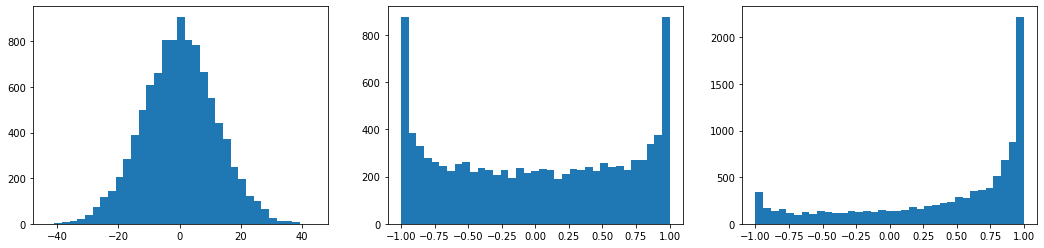

In [33]:
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.hist(data.y[:,0], 35)
plt.subplot(1,3,2)
plt.hist(data.y[:,1], 35)
plt.subplot(1,3,3)
plt.hist(data.y[:,2], 35)
plt.show()

In [ ]:
plt.plot(np.fft.fftfreq(Nu, d=dt), np.fft.fft(u).real[:])

In [ ]:
theta = np.arctan2(data.y[:,0], data.y[:,1])
plt.plot(np.fft.fftfreq(Nu, d=dt), np.fft.fft(theta).real[:])

In [ ]:
fig1 = plt.figure(figsize=(10,5))
plt_len = u.size//200
plt.subplot(1,3,1)
plt.plot(data.u[:plt_len])
plt.subplot(1,3,2)
plt.plot(data.y[:plt_len,0])
plt.subplot(1,3,3)
plt.plot(data.y[:plt_len,1])
plt.plot(np.ones(plt_len), 'r-.')
plt.plot(-1*np.ones(plt_len), 'r-.')
plt.show()

In [ ]:
from torch import nn
# change output from linear layer to ny=2 (from sin cos output), to sin and cos applied to linear layer to ny=1
    #!!! There is probably an issue with the input of the sin and cos being normalized
class sincos_output_net(nn.Module):
    def __init__(self, nx, ny, nu=-1, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(sincos_output_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.feedthrough = nu!=-1
        if self.feedthrough:
            self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
            net_in = nx + np.prod(self.nu, dtype=int)
        else:
            net_in = nx
        self.net = simple_res_net(n_in=net_in, n_out=np.prod((1,),dtype=int), n_nodes_per_layer=n_nodes_per_layer, \
            n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, x, u=None):
        xu = x
        xu = self.net(xu).view(*((x.shape[0],)+(1,)))
        y = torch.cat([torch.sin(xu), torch.cos(xu)], dim=1)
        return y
    
# change input from sin cos to arctan2 of sin cos.
    #!!! There is probably a problem with the sin and cos being normalized at the arctan2
class arctan2_encoder_net(nn.Module):
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(arctan2_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod((1,),dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        ypast = torch.mul(torch.atan2(ypast[:,:,0],ypast[:,:,1]),0.5)
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)

class SinCos_encoder(deepSI.fit_systems.SS_encoder_general):
    def __init__(self, nx=10, na=10, nb=10, na_right=0, nb_right=0, e_net_kwargs={}, f_net_kwargs={}, h_net_kwargs={}):
        super(SinCos_encoder, self).__init__(nx=nx, na=na, nb=nb, na_right=na_right, nb_right=nb_right, e_net_kwargs=e_net_kwargs, f_net_kwargs=f_net_kwargs, h_net_kwargs=h_net_kwargs)
        # self.h_net = sincos_output_net
        # self.e_net = arctan2_encoder_net

    def init_nets(self, nu, ny): # a bit weird
        na_right = self.na_right if hasattr(self,'na_right') else 0
        nb_right = self.nb_right if hasattr(self,'nb_right') else 0
        self.encoder = self.e_net(nb=(self.nb+nb_right), nu=nu, na=(self.na+na_right), ny=ny, nx=self.nx, **self.e_net_kwargs)
        self.fn =      self.f_net(nx=self.nx, nu=nu,                                **self.f_net_kwargs)
        if self.feedthrough:
            self.hn =      self.h_net(nx=self.nx, ny=ny, nu=nu,                     **self.h_net_kwargs) 
        else:
            self.hn =      self.h_net(nx=self.nx, ny=ny,                            **self.h_net_kwargs)

    def init_model(self, sys_data=None, nu=-1, ny=-1, device='cpu', auto_fit_norm=True, optimizer_kwargs={}, parameters_optimizer_kwargs={}, scheduler_kwargs={}):
        '''This function set the nu and ny, inits the network, moves parameters to device, initilizes optimizer and initilizes logging parameters'''
        if sys_data==None:
            assert nu!=-1 and ny!=-1, 'either sys_data or (nu and ny) should be provided'
            self.nu, self.ny = nu, ny
        else:
            self.nu, self.ny = sys_data.nu, sys_data.ny
            # if auto_fit_norm:
            #     self.norm.fit(sys_data)
            self.norm.ustd = 4
            self.norm.y0 = np.array([0.0,0.0])
            self.norm.ystd = np.array([1.0,1.0])
            print("1 ystd: " + str(self.norm.ystd) + ", y0: " + str(self.norm.y0))
            print("1 ustd: " + str(self.norm.ustd) + ", u0: " + str(self.norm.u0))
        self.init_nets(self.nu, self.ny)
        self.to_device(device=device)
        parameters_and_optim = [{**item,**parameters_optimizer_kwargs.get(name,{})} for name,item in self.parameters_with_names.items()]
        self.optimizer = self.init_optimizer(parameters_and_optim, **optimizer_kwargs)
        self.scheduler = self.init_scheduler(**scheduler_kwargs)
        self.bestfit = float('inf')
        self.Loss_val, self.Loss_train, self.batch_id, self.time, self.epoch_id = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
        self.init_model_done = True


In [ ]:
sys = deepSI.load_system('NonlinearController/trained_models/sincos/sincos_perturbed_nmpc_dt0_1_e50_b500_nf15_sn0_014')

In [ ]:
import NonlinearController.systems as systems

# u = np.load("NonlinearController/data/sin_perturbed_NMPC_w.npy")[0,:]
# y = np.load("NonlinearController/data/sin_perturbed_NMPC_q.npy").T
# data = deepSI.System_data(u=u, y=y)

# u = np.load("NonlinearController/data/Energy_u.npy")
# y = np.load("NonlinearController/data/Energy_y.npy")
# y = (y[:]+2*np.pi)%(2*np.pi)-np.pi
# y = np.vstack((np.sin(y),np.cos(y))).T
# data = deepSI.System_data(u=u, y=y)

Nu = 100000; a = 4.0
u = deepSI.deepSI.exp_design.multisine(Nu, pmax=Nu//2-1, n_crest_factor_optim=10)*a/2
u = np.clip(u, -a, a)
sigma_n = [0.014]; dt = 0.1
setup = systems.ReversedSinCosUnbalancedDisc(dt=dt, sigma_n=sigma_n)
data = setup.apply_experiment(deepSI.System_data(u=u))

In [ ]:
# train, test = data.train_test_split(split_fraction=0.2)
# train, val  = train.train_test_split(split_fraction=0.25)

In [ ]:
test_ss_enc = sys.apply_experiment(data)

In [ ]:
print(f'NRMS simulation SS linear  {test_ss_enc.NRMS(data):.2%}')

fig1 = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(test_ss_enc.y[:,0], label="System")
plt.plot(test_ss_enc.y[:,0] - data.y[:,0], label='Error')

plt.subplot(1,2,2)
plt.plot(test_ss_enc.y[:,1], label="System")
plt.plot(test_ss_enc.y[:,1] - data.y[:,1] + 1, label='Error')
# plt.ylim((-1,1.2))

plt.show()

In [ ]:
nsteperror = sys.n_step_error(data,nf=25)
plt.plot(nsteperror)